In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
    

def calculate_ma(data):
    
    """
    Calculate Moving Average, VWAP, and RSI for the given dataset.
    """
    # Calculate Moving Average
    data["MA9"] = data["Close"].rolling(window=9).mean()
    data["MA21"] = data["Close"].rolling(window=21).mean()
    data["MA35"] = data["Close"].rolling(window=35).mean()
    data["MA50"] = data["Close"].rolling(window=50).mean()
    data["MA100"] = data["Close"].rolling(window=100).mean()
    data["MA100"] = data["Close"].rolling(window=200).mean()

    return data

def calculate_vwap(data):
    """
    Calculate the VWAP (Volume Weighted Average Price) for the given DataFrame.
    Expects columns: 'High', 'Low', 'Close', 'Volume'.
    """
    # Ensure columns exist and are numeric
    required_columns = ["High", "Low", "Close", "Volume"]
    for col in required_columns:
        if col not in data.columns:
            raise ValueError(f"Missing required column: {col}")
    
    # Convert necessary columns to numeric
    data[required_columns] = data[required_columns].apply(pd.to_numeric, errors="coerce")
    data.dropna(subset=required_columns, inplace=True)
    
    # Calculate VWAP
    data["Typical Price"] = (data["High"] + data["Low"] + data["Close"]) / 3
    data["VWAP"] = (
        (data["Typical Price"] * data["Volume"]).cumsum() / data["Volume"].cumsum()
    )
    
    # Drop intermediate calculations if not needed
    data.drop(columns=["Typical Price"], inplace=True, errors="ignore")
    
    return data



def calculate_rsi(data, rsi_period=14):
    """
    Calculate the Relative Strength Index (RSI) for the given dataset.
    """
    delta = data["Close"].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Use rolling mean for average gain and loss
    avg_gain = gain.rolling(window=rsi_period, min_periods=1).mean()
    avg_loss = loss.rolling(window=rsi_period, min_periods=1).mean()

    # Calculate Relative Strength (RS) and RSI
    rs = avg_gain / avg_loss
    data["RSI"] = 100 - (100 / (1 + rs))

    return data

def calculate_bollinger_bands(data, bb_period=20, bb_std_dev=2):
    """
    Calculate Bollinger Bands for the given dataset.
    """
    data["BB_Mid"] = data["Close"].rolling(window=bb_period).mean()
    data["BB_Upper"] = data["BB_Mid"] + bb_std_dev * data["Close"].rolling(window=bb_period).std()
    data["BB_Lower"] = data["BB_Mid"] - bb_std_dev * data["Close"].rolling(window=bb_period).std()
    return data


def calculate_pivot_points(data):
    """
    Calculate Pivot Points and support/resistance levels.
    """
    data["PP"] = (data["High"].shift(1) + data["Low"].shift(1) + data["Close"].shift(1)) / 3
    data["S1"] = 2 * data["PP"] - data["High"].shift(1)
    data["R1"] = 2 * data["PP"] - data["Low"].shift(1)
    data["S2"] = data["PP"] - (data["High"].shift(1) - data["Low"].shift(1))
    data["R2"] = data["PP"] + (data["High"].shift(1) - data["Low"].shift(1))
    return data


def calculate_fibonacci_retracement(data, lookback=14):
    """
    Calculate Fibonacci retracement levels for the given lookback period.
    """
    data["Fib_High"] = data["High"].rolling(window=lookback).max()
    data["Fib_Low"] = data["Low"].rolling(window=lookback).min()
    data["Fib_Levels"] = data.apply(
        lambda row: {
            "0.0%": row["Fib_Low"],
            "23.6%": row["Fib_Low"] + 0.236 * (row["Fib_High"] - row["Fib_Low"]),
            "38.2%": row["Fib_Low"] + 0.382 * (row["Fib_High"] - row["Fib_Low"]),
            "50.0%": (row["Fib_High"] + row["Fib_Low"]) / 2,
            "61.8%": row["Fib_Low"] + 0.618 * (row["Fib_High"] - row["Fib_Low"]),
            "100.0%": row["Fib_High"],
        },
        axis=1,
    )
    return data.drop(columns=["Fib_High", "Fib_Low"], errors="ignore")


def calculate_indicators(data, ma_period=14, rsi_period=14):
    """
    Calculate multiple indicators, including Moving Averages, VWAP, RSI,
    Bollinger Bands, Pivot Points, and Fibonacci Retracement Levels.
    """
    data = calculate_ma(data)
    data = calculate_vwap(data)
    data = calculate_rsi(data, rsi_period)
    data = calculate_bollinger_bands(data)
    data = calculate_pivot_points(data)
    # data = calculate_fibonacci_retracement(data)
    return data


In [33]:
def fetch_and_store_data(ticker, interval, period, file_name="data.csv"):
    """
    Fetch stock data from yfinance and store it in a CSV file.
    Returns the processed DataFrame.
    """
    
    # Fetch data
    data = yf.download(ticker, interval=interval, period=period)
    if data.empty:
        print(f"No data fetched for {ticker}. Please check the ticker or interval/period.")
        return None
    
    # Reset index to include 'Date' as a column
    data.reset_index(inplace=True)
    
    # Ensure proper column names
    data.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]

    data = calculate_indicators(data)
    
    # Save to CSV with proper formatting
    data.to_csv(file_name, index=False, header=True)
    print(f"{ticker} data saved to {file_name}.")
    return data

In [34]:
# Example usage before plotting
spy_data = fetch_and_store_data("SPY", "5m", "1mo")

[*********************100%***********************]  1 of 1 completed

SPY data saved to data.csv.


In [42]:
import plotly.graph_objects as go
import pandas as pd

def plot_interactive_with_gaps_skipped(data):
    """
    Plot interactive candlestick chart with indicators and skip gaps in data.
    """
    # Ensure index is datetime
    data = data.copy()
    if not pd.api.types.is_datetime64_any_dtype(data.index):
        data.index = pd.to_datetime(data.index)

    # Create candlestick chart with corrected colors
    fig = go.Figure(
        data=go.Candlestick(
            x=data.index,
            open=data["Open"],
            high=data["High"],
            low=data["Low"],
            close=data["Close"],
            name="Candlesticks",
            increasing_line_color="green",  # Bullish candles
            decreasing_line_color="red",    # Bearish candles
        )
    )

    # Update layout
    fig.update_layout(
        title="Interactive Stock Price with Indicators (No Gaps)",
        xaxis_title="Date",
        yaxis_title="Price",
        template="plotly_dark",
        xaxis_rangeslider_visible=False,
        xaxis=dict(type="category"),
        hovermode="x unified",
        height=800,
    )

    # Show the plot
    fig.show()

# Example usage
data = pd.read_csv("data.csv", parse_dates=["Date"], index_col="Date")
plot_interactive_with_gaps_skipped(data)


In [43]:

# Load the data
data = pd.read_csv("data.csv", parse_dates=["Date"], index_col="Date")

if data is not None:
    plot_interactive_with_gaps_skipped(data)  # Plot only RTH data
    print(data.head())
else:
    print("Failed to fetch and process data for plotting.")


                                 Open        High         Low       Close  \
Date                                                                        
2024-12-04 14:30:00+00:00  605.780029  606.049988  605.510010  605.630005   
2024-12-04 14:35:00+00:00  605.619873  605.929871  605.539978  605.799988   
2024-12-04 14:40:00+00:00  605.690002  605.820007  605.590027  605.599976   
2024-12-04 14:45:00+00:00  605.780029  605.909973  605.570007  605.700012   
2024-12-04 14:50:00+00:00  606.080017  606.080017  605.832520  606.000000   

                            Volume  MA9  MA21  MA35  MA50  MA100        VWAP  \
Date                                                                           
2024-12-04 14:30:00+00:00  1945925  NaN   NaN   NaN   NaN    NaN  605.730001   
2024-12-04 14:35:00+00:00   426558  NaN   NaN   NaN   NaN    NaN  605.734785   
2024-12-04 14:40:00+00:00   268519  NaN   NaN   NaN   NaN    NaN  605.728199   
2024-12-04 14:45:00+00:00   238654  NaN   NaN   NaN   NaN   

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def apply_strategy(data, initial_capital=10000, long_entry_threshold=0.002, take_profit=0.001, stop_loss=0.0005):
    """
    Apply a simple trading strategy:
    - Long entry when price increases by long_entry_threshold.
    - Exit with take profit or stop loss based on entry price.
    """
    data["Signal"] = 0  # 1 for long, 0 for no trade
    data["Exit"] = 0    # 1 for take profit, -1 for stop loss
    data["PnL"] = 0     # Profit or loss for the trade
    data["Balance"] = initial_capital  # Track account balance

    entry_price = None
    position_active = False

    for i in range(1, len(data)):
        if not position_active:  # No active position
            # Check for long entry
            if (data["Close"].iloc[i] / data["Close"].iloc[i - 1] - 1) > long_entry_threshold:
                data.loc[data.index[i], "Signal"] = 1  # Long signal
                entry_price = data["Close"].iloc[i]
                position_active = True
                print(f"Long entry at {data.index[i]}, Entry Price: {entry_price}")
        elif position_active:  # Position is active
            current_price = data["Close"].iloc[i]
            # Check for take profit
            if (current_price / entry_price - 1) >= take_profit:
                data.loc[data.index[i], "Exit"] = 1  # Take profit
                data.loc[data.index[i], "Signal"] = 0  # Close position
                profit = take_profit * data["Balance"].iloc[i - 1]  # PnL in dollars
                data.loc[data.index[i], "PnL"] = profit
                data.loc[data.index[i], "Balance"] = data["Balance"].iloc[i - 1] + profit
                position_active = False
                print(f"Take profit at {data.index[i]}, Close: {current_price}, PnL: {profit:.2f}")
            # Check for stop loss
            elif (current_price / entry_price - 1) <= -stop_loss:
                data.loc[data.index[i], "Exit"] = -1  # Stop loss
                data.loc[data.index[i], "Signal"] = 0  # Close position
                loss = -stop_loss * data["Balance"].iloc[i - 1]  # PnL in dollars
                data.loc[data.index[i], "PnL"] = loss
                data.loc[data.index[i], "Balance"] = data["Balance"].iloc[i - 1] + loss
                position_active = False
                print(f"Stop loss at {data.index[i]}, Close: {current_price}, PnL: {loss:.2f}")

    # Forward fill balance for rows without changes
    data["Balance"] = data["Balance"].fillna(method="ffill")
    return data

ModuleNotFoundError: No module named 'matplotlib'

In [7]:
def backtest(data):
    total_trades = len(data[data["Exit"] != 0])
    total_pnl = data["PnL"].sum()
    final_balance = data["Balance"].iloc[-1]
    pnl_percentage = ((final_balance / data["Balance"].iloc[0]) - 1) * 100
    max_drawdown = ((data["Balance"].cummax() - data["Balance"]) / data["Balance"].cummax()).max()

    metrics = {
        "Total Trades": total_trades,
        "Final Balance": final_balance,
        "Total PnL": total_pnl,
        "PnL (%)": pnl_percentage,
        "Max Drawdown (%)": max_drawdown * 100,
    }
    return metrics

Long entry at 2024-09-17 09:30:00-04:00, Entry Price: 564.7650146484375
Stop loss at 2024-09-17 09:50:00-04:00, Close: 564.2899780273438, PnL: -5.00
Long entry at 2024-09-18 14:00:00-04:00, Entry Price: 565.7899780273438
Stop loss at 2024-09-18 14:05:00-04:00, Close: 565.39990234375, PnL: -5.00
Long entry at 2024-09-18 14:15:00-04:00, Entry Price: 565.7100219726562
Take profit at 2024-09-18 14:30:00-04:00, Close: 566.9390258789062, PnL: 10.00
Long entry at 2024-09-18 14:45:00-04:00, Entry Price: 565.0700073242188
Stop loss at 2024-09-18 14:55:00-04:00, Close: 563.7899780273438, PnL: -5.00
Long entry at 2024-09-18 15:10:00-04:00, Entry Price: 564.5800170898438
Stop loss at 2024-09-18 15:20:00-04:00, Close: 563.8200073242188, PnL: -5.00
Long entry at 2024-09-19 09:30:00-04:00, Entry Price: 570.030029296875
Stop loss at 2024-09-19 09:40:00-04:00, Close: 569.1699829101562, PnL: -5.00
Long entry at 2024-09-26 09:30:00-04:00, Entry Price: 573.5700073242188
Stop loss at 2024-09-26 10:05:00-04

C:\Users\Vishnu\AppData\Local\Temp\ipykernel_39300\3406889597.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["Balance"] = data["Balance"].fillna(method="ffill")


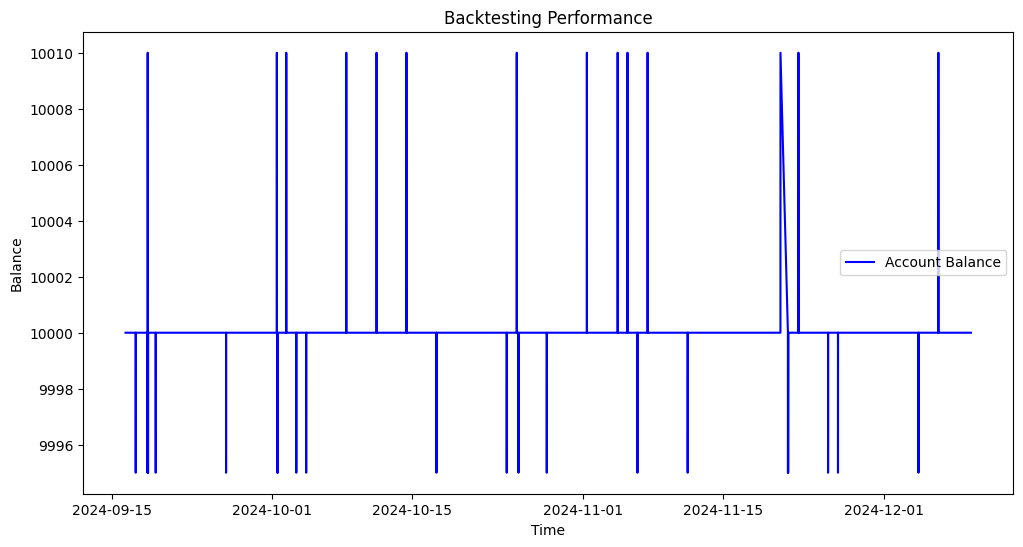

In [8]:
def plot_performance(data):
    data["Cumulative PnL"] = data["PnL"].cumsum()
    plt.figure(figsize=(12, 6))
    plt.plot(data["Balance"], label="Account Balance", color="blue")
    plt.title("Backtesting Performance")
    plt.xlabel("Time")
    plt.ylabel("Balance")
    plt.legend()
    plt.show()

# Load data and apply strategy
data = pd.read_csv("spy_5min.csv", index_col="Datetime", parse_dates=True)
data = apply_strategy(data)

# Backtest
results = backtest(data)
print(results)

# Plot performance
plot_performance(data)